### Description

Topic models are used to uncover hidden structure in a collection of texts.

LDA paper: http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf

LDA is a generative probabilistic model used to classify text in a document to a particular topic. It builds topic per document model and words per document model with usage of Drichlet distributions:
- Every document is modeled as a multinominal distribution of topics.
- Every topic is modeled as a multinominal distribution of words.

LDA algorithm requires every document to be produced from mixture of topics (there should be some themes that can be assigned).

### Imports

In [1]:
import re
from tqdm import tqdm

import gensim
import nltk
for package in ["pun|kt", "wordnet", "stopwords"]:
    nltk.download(package)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

%matplotlib inline

[nltk_data] Error loading pun|kt: Package 'pun|kt' not found in index
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kamilkrzyk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kamilkrzyk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Constants

In [2]:
DATA_LINK = "https://www.dropbox.com/s/trvggms2xx1jvsz/abcnews-date-text.csv?dl=1"
RANDOM_SEED = 2020

### Data

ABC news dataset will be used for this showcase. 
It was found on Kaggle under following [link](https://www.kaggle.com/therohk/million-headlines#abcnews-date-text.csv).
It contains over million headlines.

- Loading data

In [3]:
df_data = pd.read_csv(DATA_LINK, parse_dates=[0], infer_datetime_format=True)
df_data.shape

(1186018, 2)

- Topics per year

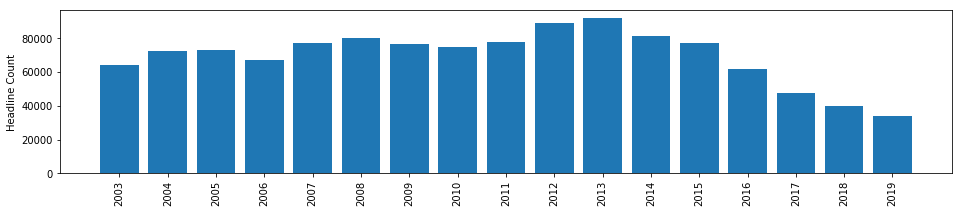

In [4]:
df_data["year"] = df_data["publish_date"].dt.year
headline_count = df_data.groupby("year")["headline_text"].count().to_frame()

plt.figure(figsize=(16,3))
indices = np.arange(0, len(headline_count.index), 1)
plt.bar(indices, headline_count["headline_text"])
plt.xticks(indices, labels=headline_count.index, rotation=90)
plt.ylabel("Headline Count");

- Getting data from last 4 years:

In [5]:
df_data = df_data.loc[df_data["year"] >= 2016]

- Creating small test dataset

In [6]:
df_test = df_data.sample(frac=0.02, replace=True, random_state=RANDOM_SEED)
df_data = df_data.loc[~df_data.index.isin(df_test.index)]

- Previewing data

In [7]:
print("Train shape: {}".format(df_data.shape), "Test shape: {}".format(df_test.shape))

Train shape: (179619, 3) Test shape: (3665, 3)


In [8]:
df_data.head(10)

,publish_date,headline_text,year
1002771,2016-01-01,1985 qld cabinet documents mabo decision,2016
1002772,2016-01-01,49ers juggle jarryd haynes talent mistakes,2016
1002773,2016-01-01,abjorensen the 2016 battlelines have been drawn,2016
1002774,2016-01-01,alex ross takes diving catch to dismiss michae...,2016
1002775,2016-01-01,ama welcome no jab; no pay vaccination policy,2016
1002776,2016-01-01,angry nix coach merrick slams odonovan headbutt,2016
1002777,2016-01-01,archbishop philip wilson to return to work,2016
1002778,2016-01-01,auroras steal show lighting up the new year ni...,2016
1002779,2016-01-01,australians flock to fireworks displays around...,2016
1002780,2016-01-01,belgium holds three people over new years atta...,2016


In [9]:
df_test.isnull().any()

publish_date     False
headline_text    False
year             False
dtype: bool

### Data Preprocessing

- Code

In [10]:
def preprocess_data(corpus, lemmatizer, stemmer, workers_num=12):
    """Operation of data cleaning and tokenization consisting of the following steps:
        1. Casting sentences to lowercase.
        2. Removing punctuation.
        3. Removing words containing digits and digits.
        4. Removing stopwords.
        5. Tokenization.
        6. Removal of tokens shorter than 3 letters.
        7. Lemmatization.
        8. Stemming.
    """

    corpus_preprocessed = []
    for i in tqdm(range(len(corpus))):
        document = corpus[i]
        document_preprocessed = []

        document_cleaned = document.lower()
        document_cleaned = re.sub(r"[^a-zA-Z0-9]", " ", document_cleaned)
        document_cleaned = re.sub(r"\w*\d\w*", "", document_cleaned)

        for token in word_tokenize(document_cleaned):
            if token not in stopwords.words("english") and len(token) > 3:
                token = stemmer.stem(token)
                token = lemmatizer.lemmatize(token)
                document_preprocessed.append(token)
        corpus_preprocessed.append(document_preprocessed)

    return corpus_preprocessed

- Preprocessing

In [11]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

corpus_preprocessed = preprocess_data(df_data["headline_text"].values, lemmatizer, stemmer)

100%|██████████| 179619/179619 [04:05<00:00, 733.10it/s]


- Visualisation

In [12]:
print("First 10 preprocessed documents:")
corpus_preprocessed[:10]

First 10 preprocessed documents:


[['cabinet', 'document', 'mabo', 'decis'],
 ['juggl', 'jarryd', 'hayn', 'talent', 'mistak'],
 ['abjorensen', 'battlelin', 'drawn'],
 ['alex', 'ross', 'take', 'dive', 'catch', 'dismiss', 'michael', 'lumb'],
 ['welcom', 'vaccin', 'polici'],
 ['angri', 'coach', 'merrick', 'slam', 'odonovan', 'headbutt'],
 ['archbishop', 'philip', 'wilson', 'return', 'work'],
 ['aurora', 'steal', 'show', 'light', 'year', 'night'],
 ['australian', 'flock', 'firework', 'display', 'around', 'countri'],
 ['belgium', 'hold', 'three', 'peopl', 'year', 'attack', 'plot']]

### Creating Bag of Words

Most of preprocessing was already done so CountVectorizer needs to be properly configured.

1. Tokens which appear in less than 15 documents will be removed.
2. Tokens which appear too often - in more than 75% of documents in corpus will be removed.



- Creating Bag of Words

In [13]:
def return_tokens(token_list):
    """Proxy function so CountVectorizer can use already preprocessed corpus where each document
    is a list of tokens.
    """
    return token_list

bow = CountVectorizer(
    analyzer="word", 
    min_df=15, 
    max_df=0.75, 
    max_features=30000,
    lowercase=False,
    tokenizer=return_tokens
)

bow.fit(corpus_preprocessed)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.75, max_features=30000, min_df=15,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function return_tokens at 0x136da17b8>, vocabulary=None)

- Preview

In [14]:
print("Number of tokens in bag: {}".format(len(bow.get_feature_names())))
print(bow.get_feature_names()[:100])

Number of tokens in bag: 6724
['aaco', 'aaron', 'abalon', 'abandon', 'abar', 'abattoir', 'abba', 'abbott', 'abc', 'abcc', 'abduct', 'abetz', 'abil', 'abl', 'ablett', 'aboard', 'abolish', 'aborigin', 'abort', 'abroad', 'absenc', 'absolut', 'abus', 'academ', 'academi', 'accc', 'acceler', 'accept', 'access', 'accid', 'accident', 'accommod', 'accord', 'account', 'accredit', 'accus', 'acdc', 'aceh', 'achiev', 'acid', 'acknowledg', 'acland', 'acquir', 'acquisit', 'acquit', 'across', 'act', 'action', 'activ', 'activist', 'actor', 'actress', 'actu', 'actual', 'ad', 'adam', 'adani', 'adapt', 'add', 'addict', 'addit', 'address', 'adel', 'adelaid', 'adfa', 'adjourn', 'adjust', 'adler', 'administr', 'admir', 'admiss', 'admit', 'adopt', 'adrian', 'adult', 'advanc', 'advantag', 'adventur', 'advertis', 'advic', 'advis', 'advisor', 'advisori', 'advoc', 'aemo', 'aerial', 'affair', 'affect', 'afford', 'afghan', 'afghanistan', 'afl', 'aflw', 'afraid', 'africa', 'african', 'aftermath', 'age', 'agenc', 'ag

- Transforming data

In [15]:
corpus_vectorized = bow.fit_transform(corpus_preprocessed)

- Previewing Sparsicity
Percentage of non-zero datapooints in the document-word matrix. 

In [16]:
print("Sparsicity: {}%".format(
    ((corpus_vectorized.todense() > 0.0).sum() / corpus_vectorized.todense().size) * 100.0)
)

Sparsicity: 0.07672396956266135%


### Building LDA

- Constructing model

Performing simple GridSearch on parameters `n_components` (number of topics) and `learning_decay` to find model with highest Log Likelihood.


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 27.3min finished


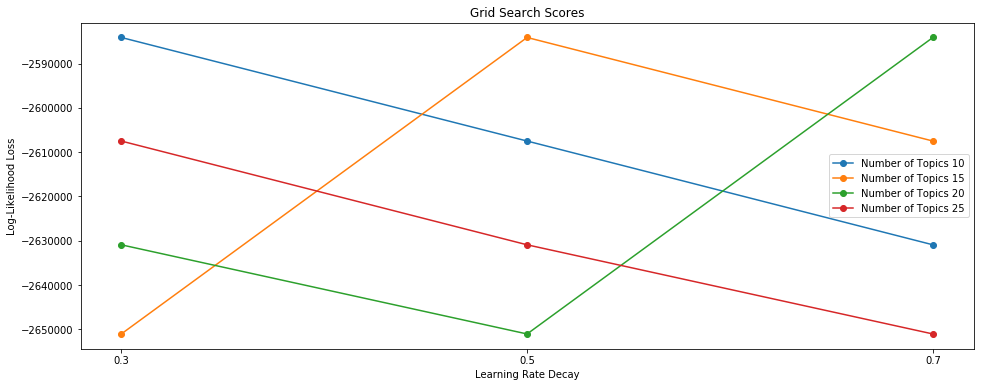

In [17]:
search_param_space = {
    "n_components": [10, 15, 20, 25], 
    "learning_decay": [0.3, 0.5, 0.7],
    "random_state": [RANDOM_SEED]
}

grid_search = GridSearchCV(
    LatentDirichletAllocation(), 
    param_grid=search_param_space, 
    verbose=1,
    n_jobs=-1,
    cv=3
)
grid_search.fit(corpus_vectorized)

scores = grid_search.cv_results_["mean_test_score"]
scores = np.array(scores).reshape(
    len(search_param_space["n_components"]), len(search_param_space["learning_decay"])
)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(16, 6)

for idx, n in enumerate(search_param_space["n_components"]):
    ax.plot(search_param_space["learning_decay"], scores[idx,:], "-o", 
            label="Number of Topics {}".format(n))
    ax.set_title("Grid Search Scores")
    ax.set_xlabel("Learning Rate Decay")
    ax.set_ylabel("Log-Likelihood Loss")
    ax.set_xticks(search_param_space["learning_decay"])
    ax.legend()
    ax.grid()

- Best model

In [18]:
model = grid_search.best_estimator_

In [19]:
model.get_params()

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.3,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': None,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 2020,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}

- Score

1. Log Likelihood: the higher value the better.
2. Preplexity: the lower value the better.

In [20]:
print("Log Likelihood: ", model.score(corpus_vectorized))
print("Perplexity: ", model.perplexity(corpus_vectorized))

Log Likelihood:  -7457915.341316427
Perplexity:  3046.865873438386


### Prediction

In [21]:
corpus_lda = model.transform(corpus_vectorized)

- Example

In [22]:
corpus_lda[:5]

array([[0.2206326 , 0.02000035, 0.61935047, 0.02000088, 0.02001027,
        0.02000273, 0.02      , 0.02000106, 0.02000147, 0.02000017],
       [0.01666667, 0.01666733, 0.34736788, 0.01666667, 0.01667124,
        0.30031153, 0.23564542, 0.01666667, 0.01666937, 0.01666723],
       [0.05      , 0.05      , 0.05      , 0.05      , 0.05000263,
        0.05      , 0.54999737, 0.05      , 0.05      , 0.05      ],
       [0.01250268, 0.01250195, 0.01250031, 0.01250328, 0.46978333,
        0.01250343, 0.01250095, 0.0125004 , 0.01250388, 0.4301998 ],
       [0.27500006, 0.27499712, 0.27499951, 0.02500001, 0.025     ,
        0.025     , 0.02500282, 0.025     , 0.02500047, 0.025     ]])

In [23]:
corpus_lda.shape

(179619, 10)

#### Dominant topic in each document

- Code

In [24]:
def color_green(value):
    """Assigns color string according to value."""
    if isinstance(value, int):
        color = "black"
    else:
        color = "green" if value > 0.1 else "black"
    return "color: {col}".format(col=color)

def make_bold(value):
    """Asigns font thickness according to value."""
    if isinstance(value, int):
        weight = 400
    else:
        weight = 700 if value > 0.1 else 400
    return "font-weight: {weight}".format(weight=weight)

- Example

In [25]:
df_dominant_topic = pd.DataFrame(
    np.round(corpus_lda, 3),
    columns = ["Topic {}".format(i) for i in range(model.n_components)],
    index = ["Doc {}".format(i) for i in range(len(corpus_lda))]
)
df_dominant_topic["Dominant Topic"] = np.argmax(df_dominant_topic.values, axis=1)
df_dominant_topic.head(20).style.applymap(color_green).applymap(make_bold)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Dominant Topic
Doc 0,0.221,0.02,0.619,0.02,0.02,0.02,0.02,0.02,0.02,0.02,2
Doc 1,0.017,0.017,0.347,0.017,0.017,0.3,0.236,0.017,0.017,0.017,2
Doc 2,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,6
Doc 3,0.013,0.013,0.013,0.013,0.47,0.013,0.013,0.013,0.013,0.43,4
Doc 4,0.275,0.275,0.275,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0
Doc 5,0.02,0.02,0.02,0.02,0.52,0.02,0.02,0.02,0.02,0.32,4
Doc 6,0.017,0.017,0.017,0.017,0.017,0.517,0.349,0.017,0.017,0.017,5
Doc 7,0.014,0.014,0.26,0.014,0.014,0.014,0.014,0.269,0.014,0.371,9
Doc 8,0.014,0.014,0.014,0.43,0.455,0.014,0.014,0.014,0.014,0.014,4
Doc 9,0.013,0.013,0.013,0.013,0.013,0.493,0.013,0.013,0.407,0.013,5


#### Topic id distribution

In [26]:
df_topic_distribution = df_dominant_topic["Dominant Topic"].value_counts().to_frame()
df_topic_distribution.index.name = "Topic Id"
df_topic_distribution.columns = ["Document Num"]
df_topic_distribution.sort_values(by="Topic Id", inplace=True)

df_topic_distribution

,Document Num
Topic Id,
0,14670
1,23871
2,14554
3,17669
4,19191
5,20957
6,14920
7,22606
8,14236


#### Topic assignment for new document

- Code

In [27]:
def predict_for_documents(documents, lda_model=model, vectorizer=bow, 
                          lemmatizer=lemmatizer, stemmer=stemmer):
    
    if isinstance(documents, list):
        documents = np.array(documents)
    elif isinstance(documents, str):
        documents = np.array([documents])
        
    documents_preprocessed = preprocess_data(documents, lemmatizer, stemmer)
    documents_vectorized = vectorizer.transform(documents_preprocessed)
    documents_lda = lda_model.transform(documents_vectorized)
    predictions = np.argmax(documents_lda, axis=1)
    return predictions, documents_lda, documents_preprocessed

- Predict topic for document

In [28]:
test_documents = df_test["headline_text"].iloc[[23, 4, 502, 1252, 3039, 1900, 12, 2712]]

predictions, documents_lda, keywords = predict_for_documents(test_documents.values)

for document, prediction, documents_lda, keyword_list in zip(
    test_documents.values, predictions, documents_lda, keywords):
    
    print("-------")
    print("Text: {}".format(document))
    print("Keywords: {}".format([k for k in keyword_list if k in bow.get_feature_names()]))
    print("Keywords out of dictionary: {}".format(
        [k for k in keyword_list if k not in bow.get_feature_names()]))
    print("Topic LDA: {}".format([np.round(lda, 3) for lda in documents_lda]))
    print("Assigned topic: {}".format(prediction))

100%|██████████| 8/8 [00:00<00:00, 584.58it/s]


-------
Text: the catalan election has been like a movie
Keywords: ['catalan', 'elect', 'like', 'movi']
Keywords out of dictionary: []
Topic LDA: [0.02, 0.02, 0.02, 0.247, 0.02, 0.272, 0.341, 0.02, 0.02, 0.02]
Assigned topic: 6
-------
Text: mav questions coroners call for dangerous trees inventory
Keywords: ['question', 'coron', 'call', 'danger', 'tree']
Keywords out of dictionary: ['inventori']
Topic LDA: [0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.85, 0.017, 0.017]
Assigned topic: 7
-------
Text: pilot walks away after small plane crash in riverland
Keywords: ['pilot', 'walk', 'away', 'small', 'plane', 'crash', 'riverland']
Keywords out of dictionary: []
Topic LDA: [0.013, 0.013, 0.013, 0.125, 0.013, 0.013, 0.013, 0.775, 0.013, 0.013]
Assigned topic: 7
-------
Text: the battle over a 3 billion dollar stonehenge tunnel
Keywords: ['battl', 'billion', 'dollar', 'tunnel']
Keywords out of dictionary: ['stoneheng']
Topic LDA: [0.52, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.32, 0.02, 

#### Topic assignment for custom text

- list

In [29]:
my_documents = [
    "sport championships in australia",
    "olympics in japan might be cancelled",
    "i like machine learning"
]

predictions, documents_lda, keywords = predict_for_documents(my_documents)

for document, prediction, documents_lda, keyword_list in zip(
    test_documents.values, predictions, documents_lda, keywords):
    
    print("-------")
    print("Text: {}".format(document))
    print("Keywords: {}".format([k for k in keyword_list if k in bow.get_feature_names()]))
    print("Keywords out of dictionary: {}".format(
        [k for k in keyword_list if k not in bow.get_feature_names()]))
    print("Topic LDA: {}".format([np.round(lda, 3) for lda in documents_lda]))
    print("Assigned topic: {}".format(prediction))

100%|██████████| 3/3 [00:00<00:00, 947.58it/s]

-------
Text: the catalan election has been like a movie
Keywords: ['sport', 'championship', 'australia']
Keywords out of dictionary: []
Topic LDA: [0.025, 0.025, 0.025, 0.025, 0.775, 0.025, 0.025, 0.025, 0.025, 0.025]
Assigned topic: 4
-------
Text: mav questions coroners call for dangerous trees inventory
Keywords: ['olymp', 'japan', 'might', 'cancel']
Keywords out of dictionary: []
Topic LDA: [0.39, 0.212, 0.02, 0.02, 0.258, 0.02, 0.02, 0.02, 0.02, 0.02]
Assigned topic: 0
-------
Text: pilot walks away after small plane crash in riverland
Keywords: ['like', 'machin', 'learn']
Keywords out of dictionary: []
Topic LDA: [0.025, 0.025, 0.775, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
Assigned topic: 2


- string

In [30]:
document = "military conflict between israel and iran"

predictions, documents_lda, keywords = predict_for_documents(document)

for document, prediction, documents_lda, keyword_list in zip(
    [document], predictions, documents_lda, keywords):
    
    print("-------")
    print("Text: {}".format(document))
    print("Keywords: {}".format([k for k in keyword_list if k in bow.get_feature_names()]))
    print("Keywords out of dictionary: {}".format(
        [k for k in keyword_list if k not in bow.get_feature_names()]))
    print("Topic LDA: {}".format([np.round(lda, 3) for lda in documents_lda]))
    print("Assigned topic: {}".format(prediction))

100%|██████████| 1/1 [00:00<00:00, 506.56it/s]

-------
Text: military conflict between israel and iran
Keywords: ['militari', 'conflict', 'israel', 'iran']
Keywords out of dictionary: []
Topic LDA: [0.61, 0.02, 0.02, 0.02, 0.02, 0.23, 0.02, 0.02, 0.02, 0.02]
Assigned topic: 0


#### Get documents with similar topic to given document

- Code

In [31]:
def recommend_similar_documents(text, corpus_lda, corpus, similarity_metric, top_n=10):
    prediction, prediction_lda, keywords = predict_for_documents(text)
    distances = similarity_metric(prediction_lda.reshape(1, -1), corpus_lda)[0]
    doc_ids = np.argsort(distances)[:top_n]
    
    print("Document: {}".format(text))
    print("------------------------")
    for i, doc_id in enumerate(doc_ids):
        print("{}. {} | {}".format(i, np.round(distances[doc_id], 7), corpus.iloc[doc_id]))

- Euclidean Distance Based

In [32]:
test_document = df_test["headline_text"].iloc[1132]

recommend_similar_documents(test_document, corpus_lda, df_data["headline_text"], 
                            similarity_metric=euclidean_distances, top_n=10)

100%|██████████| 1/1 [00:00<00:00, 284.34it/s]


Document: islamic council federation drops legal case former president
------------------------
0. 0.0121814 | apple faces lawsuits after saying it slows down ageing iphones
1. 0.0266976 | victorian chief justice urges more diversity in judicial system
2. 0.0291075 | banking royal commission anz financial advice clients interest
3. 0.0333595 | aung san suu kyi defends myanmar against genocide charges
4. 0.0415976 | mali government halves death toll from attacks
5. 0.0459213 | trach mommas louisiana fight for federal funding obamacare
6. 0.0461341 | man charged over cleaning employment scam
7. 0.0525933 | us demands russia stop syria bombing after talks suspended
8. 0.0552632 | phillipines malcolm turnbull must condemn extrajudicial killing
9. 0.0552794 | police build trust with multicultural youth


- Cosine Similarity Based

In [33]:
test_document = df_test["headline_text"].iloc[1132]

recommend_similar_documents(test_document, corpus_lda, df_data["headline_text"], 
                            similarity_metric=cosine_distances, top_n=10)

100%|██████████| 1/1 [00:00<00:00, 288.01it/s]

Document: islamic council federation drops legal case former president
------------------------
0. 0.000214 | apple faces lawsuits after saying it slows down ageing iphones
1. 0.0011956 | victorian chief justice urges more diversity in judicial system
2. 0.001407 | aung san suu kyi defends myanmar against genocide charges
3. 0.0014628 | banking royal commission anz financial advice clients interest
4. 0.0015578 | trach mommas louisiana fight for federal funding obamacare
5. 0.0020564 | mali government halves death toll from attacks
6. 0.0021412 | man charged over cleaning employment scam
7. 0.0032698 | ita buttrose statement in full on afp raids on abc
8. 0.0045816 | police build trust with multicultural youth
9. 0.0047345 | us demands russia stop syria bombing after talks suspended


### Analyzing topics

#### Previewing LDA model

In [34]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(model, corpus_vectorized, bow, mds="tsne")
panel

/Users/kamilkrzyk/.pyenv/versions/3.6.6/envs/udacity-workspace/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
7       18.707987   96.187469       1        1  12.231547
1     -166.149521 -198.251114       2        1  12.096571
5      248.734711 -139.854584       3        1  11.241595
4       95.806801  -57.165005       4        1  10.448637
9     -130.858414  196.085037       5        1  10.036195
3       38.917046 -234.329605       6        1   9.712837
6      226.086670   83.706802       7        1   8.916680
8       96.422577  253.092545       8        1   8.471517
2     -239.058029   24.431337       9        1   8.429896
0      -75.633018  -46.939617      10        1   8.414527, topic_info=     Category         Freq        Term        Total  loglift  logprob
5226  Default  4839.000000         say  4839.000000  30.0000  30.0000
4544  Default  4882.000000       polic  4882.000000  29.0000  29.0000
388   Default  5554.000000   australia  5554.000000  28.0000  28.0000
6227  Default  4229.000000       trump  4229.000000  27.0000  27.0000
389   Default  4509.000000  australian  4509.000000  26.0000  26.0000
6657  Default  2461.000000       world  2461.000000  25.0000  25.0000
3990  Default  2347.000000      murder  2347.000000  24.0000  24.0000
3687  Default  2129.000000      market  2129.000000  23.0000  23.0000
361   Default  2318.000000      attack  2318.000000  22.0000  22.0000
4032  Default  2248.000000      nation  2248.000000  21.0000  21.0000
1954  Default  3142.000000       elect  3142.000000  20.0000  20.0000
4122  Default  1906.000000       north  1906.000000  19.0000  19.0000
5249  Default  1913.000000      school  1913.000000  18.0000  18.0000
1088  Default  2866.000000       charg  2866.000000  17.0000  17.0000
1132  Default  1876.000000       china  1876.000000  16.0000  16.0000
1452  Default  1870.000000       crash  1870.000000  15.0000  15.0000
3520  Default  1736.000000        live  1736.000000  14.0000  14.0000
1220  Default  1699.000000       coast  1699.000000  13.0000  13.0000
4204  Default  1688.000000        open  1688.000000  12.0000  12.0000
1433  Default  2622.000000       court  2622.000000  11.0000  11.0000
3874  Default  1411.000000        miss  1411.000000  10.0000  10.0000
5161  Default  1395.000000       rural  1395.000000   9.0000   9.0000
1822  Default  1992.000000      donald  1992.000000   8.0000   8.0000
2868  Default  1864.000000        home  1864.000000   7.0000   7.0000
5893  Default  3025.000000      sydney  3025.000000   6.0000   6.0000
3135  Default  1515.000000        jail  1515.000000   5.0000   5.0000
4080  Default  1723.000000        news  1723.000000   4.0000   4.0000
2273  Default  2608.000000        fire  2608.000000   3.0000   3.0000
2895  Default  1368.000000      hospit  1368.000000   2.0000   2.0000
5775  Default  1160.000000     student  1160.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
5967  Topic10   208.724287        tech   209.810765   2.4700  -5.9264
3218  Topic10   167.361481       julia   168.255334   2.4699  -6.1472
2047  Topic10   163.306666       erupt   164.200542   2.4698  -6.1718
3673  Topic10   160.264225       marcu   161.159453   2.4696  -6.1906
4670  Topic10   351.953549      profit   355.709232   2.4646  -5.4039
3220  Topic10   227.530725        jump   229.048525   2.4686  -5.8401
2454  Topic10   204.588007        gain   205.758315   2.4695  -5.9464
6151  Topic10   792.935694       trade   816.270257   2.4462  -4.5917
6008  Topic10   272.691630        thai   276.712515   2.4606  -5.6591
1132  Topic10  1626.092359       china  1876.098187   2.3322  -3.8735
4457  Topic10   295.012558   philippin   306.815648   2.4360  -5.5804
3113  Topic10  1083.431581      island  1386.135950   2.2288  -4.2795
1611  Topic10   442.023511       decis   500.622824   2.3507  -5.1760
2170  Topic10   807.008618        fall  1028.969763   2.2322  -4.5741
354   Topic10   317.550669      asylum   

#### Word Importance vs Topic

In [35]:
cols = 10

df_topic_word_importance = pd.DataFrame(model.components_)
df_topic_word_importance.columns = bow.get_feature_names()
df_topic_word_importance.index = ["Topic {}".format(i) for i in range(model.n_components)]
df_topic_word_importance[df_topic_word_importance.columns[-cols:]].head(model.n_components)

,zali,zealand,zero,zika,zimbabw,zinc,zombi,zone,zuckerberg,zuma
Topic 0,0.100000,26.096559,0.100005,0.100005,0.103629,0.100018,0.100009,1.396984,0.100009,0.100001
Topic 1,0.100005,0.100102,89.099947,0.100073,0.100004,0.100014,24.764277,39.501980,0.100008,0.100005
Topic 2,0.100001,0.100007,0.100004,102.474485,0.100003,0.100001,0.100006,19.987992,0.100007,0.100001
Topic 3,0.100001,368.871076,0.100012,0.100004,0.100008,0.100006,0.100021,17.627514,0.100008,0.100026
Topic 4,16.099979,112.331988,0.100006,0.100010,65.245353,0.100003,0.100006,0.100007,0.100005,0.100005
Topic 5,0.100001,0.100235,0.100003,0.100004,0.100016,0.100000,0.100011,0.100005,36.099954,27.077752
Topic 6,0.100003,0.100007,0.100009,15.759991,0.100225,0.100004,6.314846,0.100013,0.100005,0.100003
Topic 7,0.100000,0.100006,0.100009,1.065411,0.100008,19.099932,0.100011,39.946794,0.100001,0.100001
Topic 8,0.100000,0.100010,0.100002,0.100014,0.100006,0.100015,4.220802,20.138703,0.100001,0.100003
Topic 9,0.100009,0.100009,0.100003,0.100004,15.950747,0.100008,0.100011,0.100008,0.100001,0.122202


In [36]:
df_topic_word_importance.shape

(10, 6724)

#### Key words for topic

In [37]:
top_keywords_num = 6

top_keywords_indices = np.argsort(df_topic_word_importance.values)[:, -top_keywords_num:][:, ::-1]

df_top_keywords = pd.DataFrame(
    np.array(bow.get_feature_names())[top_keywords_indices],
    columns = ["Word {}".format(i) for i in range(top_keywords_num)],
    index = ["Topic {}".format(i) for i in range(model.n_components)]
)

df_top_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5
Topic 0,market,north,china,street,island,trump
Topic 1,say,govern,plan,power,industri,farmer
Topic 2,nation,school,live,coast,rural,student
Topic 3,world,busi,australia,countri,deal,life
Topic 4,australia,australian,open,test,win,first
Topic 5,polic,trump,attack,charg,donald,shoot
Topic 6,elect,liber,campaign,drug,find,parti
Topic 7,crash,home,fire,hospit,indigen,health
Topic 8,miss,drum,high,fund,peopl,search
Topic 9,murder,court,jail,sydney,found,charg
